In [1]:
import pymust, pymust.utils
import numpy as np, matplotlib.pyplot as plt, scipy, scipy.io


A rotating disk (diameter of 2 cm) was insonified by a series of 32
unsteered plane waves with a Verasonics scanner, and a linear transducer,
at a PRF (pulse repetition frequency) of 10 kHz. The RF signals were
downsampled at 4/3 times (5 MHz) = 6.66 MHz. The properties of the
linear array were:

- 128 elements
- center frequency = 5 MHz
- pitch = 0.298 mm%%


In [2]:
# Download the experimental RF data. The 3-D array RF contains 128 columns
# (as the transducer contained 128 elements), and its length is 32 in the
# third dimension (as 32 plane waves were transmitted).
dataMatlab = scipy.io.loadmat('Data/PWI_disk.mat', struct_as_record = False); #ok
RF = dataMatlab['RF'].astype(float)


In [3]:
#Parse params
param = pymust.utils.Param();
for k, c in dataMatlab['param'][0][0].__dict__.items():
    if k != '_fieldnames':
        if c.size == 1:
            c = c[0][0]
        param[k] = c

In [5]:
#% Create a 2.5-cm-by-2.5-cm image grid.
dx = 1e-4; # grid x-step (in m)
dz = 1e-4; # grid z-step (in m)
x,z = np.meshgrid(np.arange(-1.25e-2, 1.25e-2 +dx,dx), np.arange(1e-2, 3.5e-2+dz-1e-6, dz));


In [18]:
RF.shape

(334, 128, 32)

In [20]:
M.dtype

dtype('complex128')

In [26]:
%%timeit

# Demodulate the RF signals with RF2IQ.
IQ =pymust.rf2iq(RF,param); 

# Create a Delay-And-Sum DAS matrix with DASMTX.
param.fnumber = None; # an f-number will be determined by DASMTX
M = pymust.dasmtx(1j*np.array(IQ.shape[:2]),x,z,param, 'nearest') #nearest does not work

# Beamform
IQb = M @ IQ.reshape(-1, RF.shape[2])
IQb = IQb.reshape(x.shape[0], x.shape[1], RF.shape[2])

I = pymust.bmode(IQb,30);
doppler, doppler_var = pymust.iq2doppler(IQb, param)
VN = pymust.getNyquistVelocity(param)


/Users/gbernardino/pymust/src/pymust/iq2doppler.py:109: RuntimeWarning: overflow encountered in scalar multiply
  VN = c*PRF/4/fc/lag; #% Nyquist velocity
/Users/gbernardino/pymust/src/pymust/iq2doppler.py:135: RuntimeWarning: overflow encountered in scalar multiply
  return  param.c*PRF/4/param.fc/lag


682 ms ± 29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
M @ IQ.reshape(-1, RF.shape[2])

array([[ 1043.75942521 +393.28573606j,  -110.59674674 -794.7907838j ,
          155.97024474  +19.16469254j, ...,
          640.05718968  +79.877806j  ,    47.97989278+1650.34056168j,
         -786.16390502+1323.92393539j],
       [ 2120.85562304+1052.11123787j,   449.89643897 +473.17923728j,
        -2608.15759155  -45.45656041j, ...,
          269.26341772-1415.41186441j,  -448.39690033-2219.91092253j,
          268.33542192-2998.85409566j],
       [ -709.59873315 -475.67716058j,  -279.17991451-2085.20116294j,
         1562.51252753 +590.63287135j, ...,
        -1943.1324732  +197.70210888j,  -459.72749632 +978.46788931j,
         -769.83180953+1284.49579019j],
       ...,
       [ 2038.61650079-1722.36609223j,   762.66729482-1193.9384699j ,
        -1016.10629388 +895.42186554j, ...,
         2511.86589386+1001.69833543j,  1270.01473896 +886.98610086j,
         1889.04382837+1185.07157389j],
       [-3954.04195746-2266.62318821j,  -101.54895284+1101.5181209j ,
         1827.17382357

Text(0, 0.5, 'Distance to the transducer [cm]')

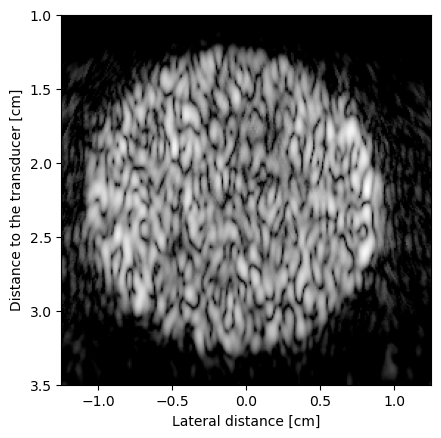

In [13]:
plt.imshow(I[:,:, 0], cmap ='gray', extent = [-1.25, 1.25, 3.5, 1])
plt.xlabel('Lateral distance [cm]')
plt.ylabel('Distance to the transducer [cm]')



/Users/gbernardino/pymust/src/pymust/iq2doppler.py:109: RuntimeWarning: overflow encountered in scalar multiply
  VN = c*PRF/4/fc/lag; #% Nyquist velocity
/Users/gbernardino/pymust/src/pymust/iq2doppler.py:135: RuntimeWarning: overflow encountered in scalar multiply
  return  param.c*PRF/4/param.fc/lag


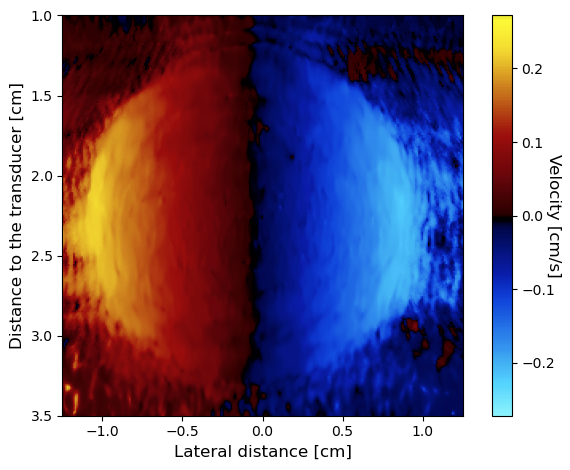

In [9]:

plt.imshow(doppler*100,  cmap = pymust.getDopplerColorMap().cmap, vmin = -VN*100, vmax = VN*100, extent = [-1.25, 1.25, 3.5, 1])
cbar = plt.colorbar()
cbar.set_label('Velocity [cm/s]', rotation=270, fontsize = 12)
plt.xlabel('Lateral distance [cm]', fontsize = 12)
plt.ylabel('Distance to the transducer [cm]', fontsize = 12)
plt.tight_layout()

In [16]:
%%timeit
param.ROI = np.median(I,2)>64

# Track the speckles with SPTRACK.
param.winsize = np.array([[32,32], [16,16]]); # size of the subwindows
param.iminc = 4; # image increment
Di,Dj,id,jd = pymust.sptrack(I,param);


215 ms ± 7.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# All three images together

Text(0.5, 1.0, 'Speckle tracking')

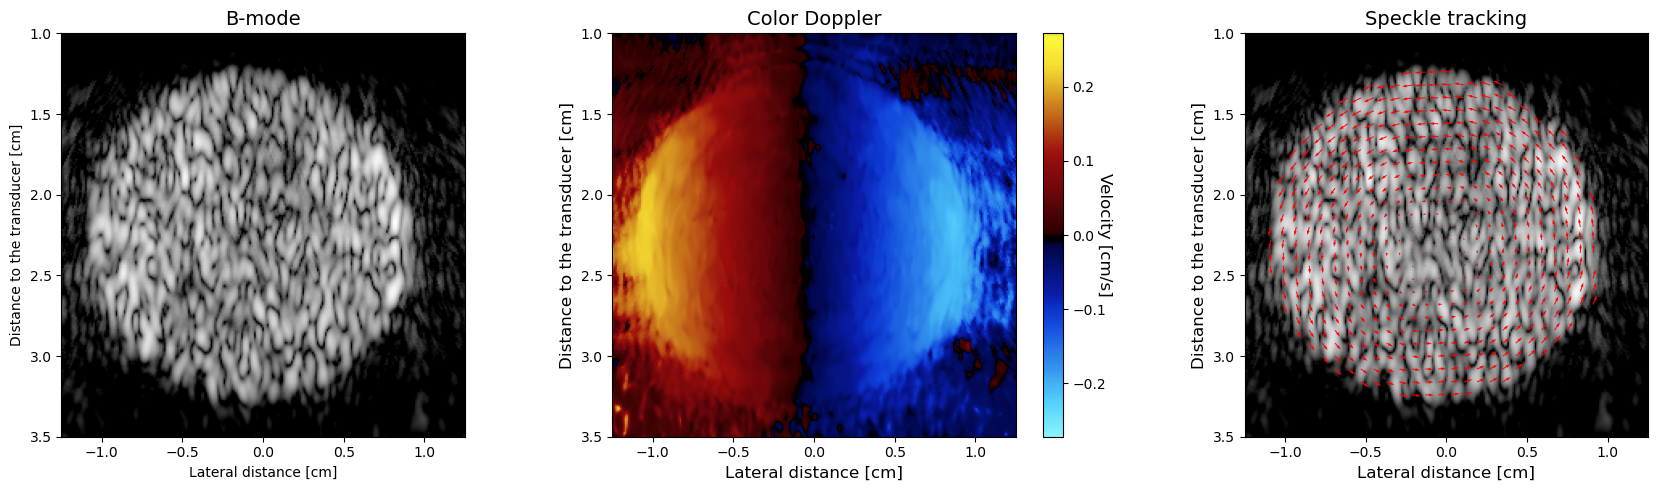

In [11]:
_, (f1, f2, f3) = plt.subplots(1,3, figsize = (18, 5))
plt.sca(f1)
plt.imshow(I[:,:, 0], cmap ='gray', extent = [-1.25, 1.25, 3.5, 1])
plt.xlabel('Lateral distance [cm]')
plt.ylabel('Distance to the transducer [cm]')
plt.title('B-mode', fontsize = 14)

plt.sca(f2)
plt.imshow(doppler*100,  cmap = pymust.getDopplerColorMap().cmap, vmin = -VN*100, vmax = VN*100, extent = [-1.25, 1.25, 3.5, 1])
cbar = plt.colorbar()
cbar.set_label('Velocity [cm/s]', rotation=270, fontsize = 12)
plt.xlabel('Lateral distance [cm]', fontsize = 12)
plt.ylabel('Distance to the transducer [cm]', fontsize = 12)
plt.tight_layout()
plt.title('Color Doppler', fontsize = 14)

plt.sca(f3)
plt.imshow(I[:,:,0], cmap = 'gray', extent = [-1.25, 1.25, 3.5, 1])
#Need the option of origin = lower, otherwise it will mess up the orientation of the quiver
#https://stackoverflow.com/questions/42776583/superimpose-matplotlib-quiver-on-image
plt.quiver(id *dx *100 - 1.25, jd*dz*100 +1, -Di*dx*100, Dj*dz*100, color = 'r') # Displacement is always in image coordinates, therefore need to change the sense of Di
plt.xlabel('Lateral distance [cm]', fontsize = 12)
plt.ylabel('Distance to the transducer [cm]', fontsize = 12)
plt.title('Speckle tracking', fontsize = 14)
